<a href="https://colab.research.google.com/github/limweiliang/weed-classifier/blob/main/CS3244_ProjectCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!nvidia-smi

Mon Nov  1 16:20:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   61C    P5    18W /  N/A |   1171MiB /  6144MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math

In [8]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9

# ds = tfds.load('deep_weeds', batch_size = -1, as_supervised= True)
# images, labels = ds['train'] # Type: EagerTensor

# # Shuffle the dataset
# images = tf.random.shuffle(images, seed=RANDOM_STATE)
# labels = tf.random.shuffle(labels, seed=RANDOM_STATE)

# print(images.shape, labels.shape)

# # Split dataset into train-val-test
# num_images = images.shape[0]
# last_train_image = math.floor(num_images * 0.6)
# last_val_image = math.floor(num_images * 0.8)

# X_train = images[:last_train_image]
# y_train = labels[:last_train_image]
# X_val = images[last_train_image:last_val_image]
# y_val = labels[last_train_image:last_val_image]
# X_test = images[last_val_image:]
# y_test = labels[last_val_image:]

# print(X_train.shape, X_val.shape, X_test.shape)

In [10]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 96
Number of validation samples: 28
Number of test samples: 14


In [11]:
# Clean up memory usage
# del ds
# del images
# del labels

In [12]:
from tensorflow.keras import datasets, layers, models, regularizers
import datetime

In [20]:
model = models.Sequential()

#Data Augmentation
model.add(layers.RandomFlip("horizontal_and_vertical", input_shape = (256,256,3)))
model.add(layers.RandomRotation((-0.2,0.2), fill_mode = "nearest"))
model.add(layers.Rescaling(1/255, input_shape = (256,256,3)))

model.add(layers.Conv2D(96, (11, 11), activation='relu', input_shape=(256, 256, 3), strides = 4))
model.add(layers.MaxPooling2D((3, 3), strides = 2))
model.add(layers.BatchNormalization())



model.add(layers.Conv2D(256, (5, 5), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((3, 3), strides = 2))

model.add(layers.Conv2D(256, (5, 5), activation='relu', padding = 'same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (5, 5), activation='relu', padding = 'same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((3, 3), strides = 2))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(4096, activation='relu'))

model.add(layers.Dense(9))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_2 (RandomFlip)   (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 256)      

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# hist = model.fit(x = X_train, y = y_train, epochs=200, 
#                     validation_data= (X_val, y_val), callbacks = [EarlyStop], batch_size = 64)

hist = model.fit(train_ds, epochs=200, 
                     validation_data= validation_ds, callbacks = [EarlyStop], batch_size = BATCH_SIZE)

Epoch 1/200
96/96 [==============================] - 30s 300ms/step - loss: 2.1485 - accuracy: 0.5086 - val_loss: 2.1538 - val_accuracy: 0.3872
Epoch 2/200
96/96 [==============================] - 29s 302ms/step - loss: 1.5435 - accuracy: 0.5246 - val_loss: 1.7540 - val_accuracy: 0.5017
Epoch 3/200
96/96 [==============================] - 29s 305ms/step - loss: 1.4316 - accuracy: 0.5266 - val_loss: 1.7740 - val_accuracy: 0.4997
Epoch 4/200
96/96 [==============================] - 29s 302ms/step - loss: 1.3773 - accuracy: 0.5321 - val_loss: 3.4235 - val_accuracy: 0.3070
Epoch 5/200
96/96 [==============================] - 29s 308ms/step - loss: 1.3211 - accuracy: 0.5414 - val_loss: 2.2742 - val_accuracy: 0.3955
Epoch 6/200
96/96 [==============================] - 30s 311ms/step - loss: 1.2551 - accuracy: 0.5574 - val_loss: 2.4817 - val_accuracy: 0.2601
Epoch 7/200
96/96 [==============================] - 29s 300ms/step - loss: 1.2130 - accuracy: 0.5718 - val_loss: 4.1276 - val_accuracy:

96/96 [==============================] - 28s 294ms/step - loss: 0.4830 - accuracy: 0.8263 - val_loss: 2.4042 - val_accuracy: 0.5494
Epoch 58/200
96/96 [==============================] - 28s 296ms/step - loss: 0.4893 - accuracy: 0.8300 - val_loss: 2.1523 - val_accuracy: 0.5514
Epoch 59/200
96/96 [==============================] - 28s 296ms/step - loss: 0.4681 - accuracy: 0.8318 - val_loss: 2.3698 - val_accuracy: 0.5226
Epoch 60/200
96/96 [==============================] - 29s 298ms/step - loss: 0.4598 - accuracy: 0.8362 - val_loss: 1.6176 - val_accuracy: 0.6402
Epoch 61/200
96/96 [==============================] - 29s 297ms/step - loss: 0.4676 - accuracy: 0.8336 - val_loss: 3.0201 - val_accuracy: 0.4298
Epoch 62/200
96/96 [==============================] - 29s 299ms/step - loss: 0.4502 - accuracy: 0.8442 - val_loss: 1.1182 - val_accuracy: 0.6793
Epoch 63/200
96/96 [==============================] - 28s 296ms/step - loss: 0.4391 - accuracy: 0.8433 - val_loss: 1.3472 - val_accuracy: 0.659

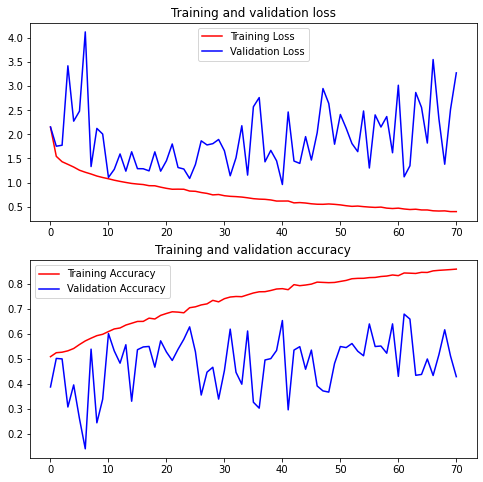

In [23]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Plot the graph manually
epochs = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [24]:
model.evaluate(validation_ds)

28/28 [==============================] - 2s 70ms/step - loss: 0.9586 - accuracy: 0.6536


[0.9586070775985718, 0.6536265015602112]

In [26]:
test_model = models.Sequential(model.layers[2:])
test_model.set_weights(model.get_weights())
test_model.summary()
test_model.compile()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 256)       614656    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 256)      

In [ ]:
#test_model.save('./CNN_weights/CNN_2.h5')

In [ ]:
# y_pred = test_model.predict(X_test, y_test)
# y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index

In [27]:
test = tfds.as_numpy(test_ds)
y_pred = []
y_label = []

for i in test:
  flat_img = i[0]
  flat_label = i[1]
  pred = test_model.predict(flat_img)
  pred = np.argmax(pred, axis=1)
  y_pred.extend(pred)
  y_label.extend(flat_label)

y_pred = np.array(y_pred)
y_label = np.array(y_label)

In [ ]:
len(y_pred)

In [28]:
from sklearn.metrics import classification_report

print(y_pred)
print(classification_report(y_label, y_pred))

[1 1 4 ... 7 8 4]
              precision    recall  f1-score   support

           0       0.33      0.37      0.35       103
           1       0.50      0.63      0.56        90
           2       0.40      0.15      0.22       116
           3       0.32      0.75      0.45       105
           4       0.45      0.82      0.58       108
           5       0.71      0.60      0.65        98
           6       0.91      0.55      0.69       114
           7       0.51      0.64      0.56       129
           8       0.86      0.70      0.77       888

    accuracy                           0.63      1751
   macro avg       0.56      0.58      0.54      1751
weighted avg       0.69      0.63      0.64      1751

